Example CNN just using one LiDAR Scene, by Jacob Igo - Paragon Autonomous

In [74]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_lidar_pkl(file_path):
    with open(file_path, 'rb') as f:
        lidar_data = pickle.load(f)  #data is stored as an array (N,5) [x,y,z,i,t]
    return lidar_data

lidar_df = load_lidar_pkl('C:\\temp-Pandaset\\theSet\\001\\lidar\\00.pkl')
print(lidar_df)

                x          y         z     i             t  d
index                                                        
0      -58.457199 -61.269268  2.881014  39.0  1.557540e+09  0
1      -71.572182 -74.840317  1.279183   9.0  1.557540e+09  0
2      -42.442833 -44.357426  0.426503  56.0  1.557540e+09  0
3      -31.749357 -33.156342 -0.025245   3.0  1.557540e+09  0
4       -9.920758 -10.442794  1.010120   0.0  1.557540e+09  0
...           ...        ...       ...   ...           ... ..
169166  41.139096  11.530556  5.419758  17.0  1.557540e+09  1
169167  34.511274  24.490057  5.673317  27.0  1.557540e+09  1
169168  41.091265  11.598719  5.408523  20.0  1.557540e+09  1
169169  34.505630  24.584497  5.678679   3.0  1.557540e+09  1
169170  41.037545  11.669248  5.396468  20.0  1.557540e+09  1

[169171 rows x 6 columns]


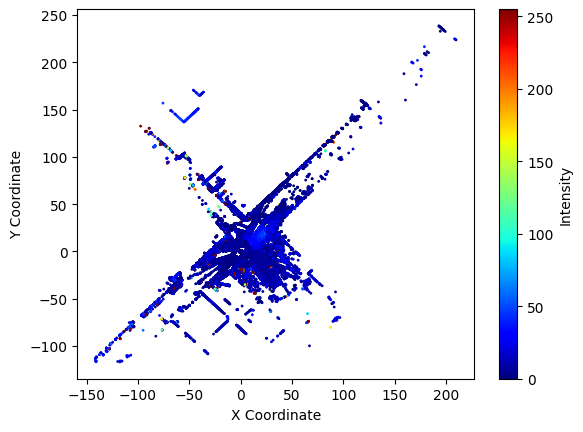

In [75]:
plt.scatter(lidar_df['x'], lidar_df['y'], s=1, c=lidar_df['i'], cmap='jet')  # Scatter plot of points
plt.colorbar(label="Intensity")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

In [76]:
def load_multiple_lidar_pkl(folder_path):
    bev_images = []
    labels = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pkl"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'rb') as f:
                lidar_points = pickle.load(f)  #(N,5) [x,y,z,i,t]
            
            #Convert to BEV
            bev_image = point_cloud_to_bev(lidar_points)  
            bev_images.append(bev_image)
            
            #Example: Assign a label based on the filename (modify as needed)
            label = int(file_name.split('_')[-1].replace('.pkl', ''))  # Extract label from filename
            labels.append(label)

    return np.array(bev_images), np.array(labels)

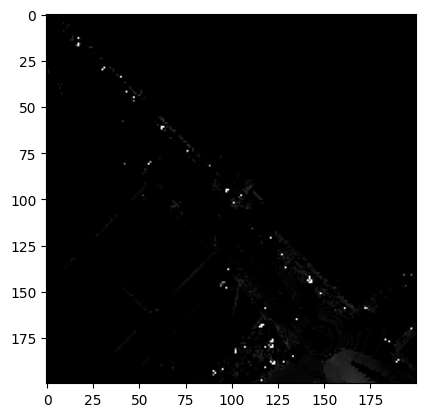

In [77]:
#Convert Point Cloud to BEV (Bird's-Eye View) Image
def point_cloud_df_to_bev(lidar_df, resolution=0.8, image_size=(200, 200)):
    bev_image = np.zeros(image_size)
    min_x, max_x = lidar_df['x'].min(), lidar_df['x'].max()
    min_y, max_y = lidar_df['y'].min(), lidar_df['y'].max()
    
    #normalize
    for _, row in lidar_df.iterrows():
        x, y, z, intensity, t, d = row
        bev_x = int((x - min_x) / resolution)
        bev_y = int((y - min_y) / resolution)
        
        if 0 <= bev_x < image_size[0] and 0 <= bev_y < image_size[1]:
            bev_image[bev_x, bev_y] = intensity  #intensity as feature

    return bev_image

bev_image = point_cloud_df_to_bev(lidar_df)
plt.imshow(bev_image, cmap='gray')
plt.show()

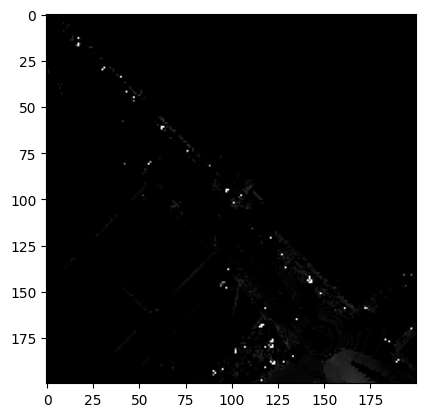

In [78]:
bev_image = bev_image / np.max(bev_image)  #normalize between 0-1
plt.imshow(bev_image, cmap='gray')
plt.show()

In [79]:
#CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):  #5 categories
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 50 * 50, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  #flatten data
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [80]:
#Prepare Data for Training
def prepare_data(bev_images, labels):
    bev_images = np.array(bev_images, dtype=np.float16)
    #bev_images = (bev_images / np.max(bev_images) * 255).astype(np.uint8)
    
    bev_images = np.expand_dims(bev_images, axis=1)  #add channel dimension
    X_train, X_test, y_train, y_test = train_test_split(bev_images, labels, test_size=0.2, random_state=42)
    
    train_dataset = data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_dataset = data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    
    train_loader = data.DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = data.DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    return train_loader, test_loader

In [81]:
#example placeholder labels (replace with actual labels)
labels = np.random.randint(0, 5, size=len(lidar_points))
subset_size = min(len(bev_image), 140000)  #max samples, (not enough CPU)
idx = np.random.choice(len(bev_image), subset_size, replace=False)
bev_image = bev_image[idx]
labels = labels[idx]

#bev_images = torch.tensor(bev_image, dtype=torch.float32)
#labels = torch.tensor(labels, dtype=torch.long)
train_loader, test_loader = prepare_data([bev_images]*len(labels), labels)

In [82]:
#Train the CNN Model
def train_model(model, train_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

model = SimpleCNN()
train_model(model, train_loader)

Epoch 1/5, Loss: 1.6061
Epoch 2/5, Loss: 1.6404
Epoch 3/5, Loss: 1.5811
Epoch 4/5, Loss: 1.5478
Epoch 5/5, Loss: 1.4864


In [83]:
#Predict a New LiDAR Point

def predict(model, bev_image):
    model.eval()
    bev_image = torch.tensor(bev_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  #batch & channel dims
    with torch.no_grad():
        output = model(bev_image)
    predicted_class = torch.argmax(output, dim=1).item()
    return predicted_class

#Example prediction
predicted_label = predict(model, bev_image)
print(f"Predicted label: {predicted_label}")

Predicted label: 1
